Price  forecasting for 6 crypto currencies based on last one-two year data

In [0]:
import warnings
warnings.filterwarnings("ignore")


In [0]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import *   
from math import * 

from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from fbprophet import Prophet
import talib

# Functions

In [0]:
def stat_model (pipeline, param_grid, X_train,X_test,y_train,  cv=3):    
  #get returns as y_pred
  y_train = calc_returns(y_train['NextDayPrice'], X_train["Close"]) 
  close_prices_test= X_test["Close"]  

  clf = GridSearchCV(pipeline ,param_grid=param_grid,  cv=cv)
  clf.fit(X_train,y_train) 
  model = clf.best_estimator_ 
  model.fit(X_train,y_train)
  y_pred= model.predict(X_test)

  #convert returns to price
  y_pred = calc_price (close_prices_test, y_pred)
  return model.__class__.__name__, model, y_pred
  
def analyze_results(y_test, y_pred):
  rmse= sqrt( mean_squared_error(y_test, y_pred ))
  mae= mean_absolute_error (y_test,y_pred)
  r2= r2_score(y_test,y_pred)
  avg_y = y_test.mean()[0]
  min_y = y_test.min()[0]
  max_y = y_test.max()[0]


  results =  pd.DataFrame()
  results["score"]= pd.Series([str(min_y)+'-'+str(max_y),avg_y, rmse,mae,r2])

  results.index = ['Price Range','Average Value','rmse','mae','r2']
  
  #plot y_test vs y_pred
  df =  pd.DataFrame()
  df["y_test"] = y_test["NextDayPrice"]
  df["y_pred"] = 0.0
  ctr = 0
  for v in y_pred:
      df.iloc[ctr,1] = y_pred[ctr] 
      ctr = ctr+1
  fig, ax1 = plt.subplots()
  ax1.plot(df.index, df['y_test'], 'g-', label= "y_test")
  ax1.plot(df.index, df['y_pred'], 'b-', label= "y_pred")
  ax1.legend()
  plt.show()
  return results

In [0]:
def split_data(data,testdays,predict_day=1):
  data['NextDayPrice'] = data["Close"].shift(-1* predict_day)

  features = data.iloc[:-1,:-1]
  labels = data.iloc[:-1,-1:] 
  if predict_day > testdays:
    testdays =predict_day+1

  # X_train, X_test, y_train, y_test = \
  #             train_test_split(features, labels , random_state=42)
  X_train= features[:-1 * testdays]
  y_train= labels[:-1 * testdays]

  X_test= features[-1 * testdays:]
  y_test= labels[-1 * testdays:]
  
  return X_train, X_test,y_train,y_test

def calc_returns(newprice,oldprice):
  return ((newprice-oldprice)/oldprice).as_matrix()

def calc_price(oldprice,est_return):
  return oldprice * (1+ est_return)

In [0]:
def run_nextday_return_pipeline (pipeline, param_grid ,prev_returns_to_be_added,  testdays, x_test =None):
  currency_list = ['Bitcoin','Ethereum','Ripple',
                   'Tron',
                   'Cardano']   
 
  nextday_returns_models = {}          
  for cur in currency_list:
      print (cur)
      filepath = './data/'+cur + '.csv'
      tweeterfilepath= './data/'+cur + '_tweets.csv'
      data = getData(filepath ,tweeterfilepath,prev_returns_to_be_added)

      X_train, X_test,y_train,y_test = split_data(data,testdays)
      if x_test is not None: 
        X_test = x_test
        
      (model_name, model,y_pred) =  stat_model (pipeline, param_grid, X_train, X_test, y_train)
      
      nextday_returns_models[cur] = model 
      print( analyze_results(y_test, y_pred) )
  return nextday_returns_models




In [0]:

def run_next_n_th_day_return_pipeline (pipeline, param_grid ,prev_returns_to_be_added,  testdays, x_test =None , day =1):
  currency_list = ['Bitcoin','Ethereum','Ripple',
                   'Tron',
                   'Cardano']   
 
  nextday_returns_models = {}          
  for cur in currency_list:
      print (cur)
      filepath = './data/'+cur + '.csv'
      tweeterfilepath= './data/'+cur + '_tweets.csv'
      data = getData(filepath ,tweeterfilepath,prev_returns_to_be_added)

      X_train, X_test,y_train,y_test = split_data(data,testdays, predict_day=day)
      if x_test is not None: 
        X_test = x_test
        
      (model_name, model,y_pred) =  stat_model (pipeline, param_grid, X_train, X_test, y_train)
      
      nextday_returns_models[cur] = model 
      print( analyze_results(y_test[:testdays - day], y_pred[:testdays-day]) )
  return nextday_returns_models

In [0]:
def run_nextwholemonth_return_pipeline (pipeline, param_grid ,prev_returns_to_be_added,  testdays, x_test =None):
  currency_list = ['Bitcoin','Ethereum','Ripple',
                   'Tron',
                   'Cardano']   
 
  nextwholemonth_returns_models = {}          
  for cur in currency_list:
      print (cur)
      filepath = './data/'+cur + '.csv'
      tweeterfilepath= './data/'+cur + '_tweets.csv'
      data = getData(filepath ,tweeterfilepath,prev_returns_to_be_added)
      nextwholemonth_returns_models[cur] = {}
      
      models ={}
      for i in range(1,30):
        print('building model for predicting :'+cur + ' returns on day : ' + str(i) + '')
        X_train, X_test,y_train,y_test = split_data(data,testdays, predict_day=i)
        if x_test is not None: 
          X_test = x_test        
        (model_name, model,y_pred) =  stat_model (pipeline, param_grid, X_train, X_test, y_train)
        models[i] =model
       
      nextwholemonth_returns_models[cur]["data"]  =  data
      nextwholemonth_returns_models[cur]["models"] =  models
        
  return nextwholemonth_returns_models

# Get Data

## Generate Twitter Sentiments

In [0]:
import re
from textblob import TextBlob

def get_tweet_sentiments(tweet_filepath):
  df = pd.read_csv(tweet_filepath, index_col=0)
  df["Date"] = pd.DatetimeIndex(df["created_at"]).date

  df["tweet_sentiment_actions"] =df["Likes"] + df["Retweet"] +1 # to handle 0likes/retweets
  df["tweet_sentiment_polarity"] =0.0
  df["tweet_sentiment_subjectivity"] =0.0

  #add sentiment columns
  for idx,row in df.iterrows():
    #clean tweet text by removing links, special characters
    tweet_txt =' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", row["text"]).split())
    # create TextBlob object of passed tweet text
    tweet_sentiment = TextBlob(tweet_txt).sentiment  
    df["tweet_sentiment_polarity"]=  tweet_sentiment.polarity
    df["tweet_sentiment_subjectivity"] = tweet_sentiment.subjectivity
    
  df["tweet_sentiment_score"] = df["tweet_sentiment_polarity"] * df["tweet_sentiment_actions"] *df["tweet_sentiment_subjectivity"] 
  return df[["Date","tweet_sentiment_score"]].groupby("Date").sum()
 

##  Get all data

In [0]:

import statsmodels.api as sm

def getData(filepath, tweeterfilepath,prev_returns_to_be_added):
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime( df["Date"]) 
    
    df = df.set_index(df["Date"], drop =True)   
    
    df.drop(df.columns[0], axis=1 ,inplace=True)
    df.drop(["Date"], axis=1 ,inplace=True)
    
    print("Get previous days high, low, market cap, open, volume")
    df["PrevHigh"]= df["High"].shift(1)
    df["PrevLow"]= df["Low"].shift(1)
    df["PrevMarket Cap"]= df["Market Cap"].shift(1)
    df["PrevOpen"]= df["Open"].shift(1)
    df["PrevVolume"]= df["Volume"].shift(1)    
    df.drop(["High","Low","Market Cap", "Open","Volume"], axis=1 ,inplace=True)
    df = df.sort_index ( ascending = True) 
    
    print('Add previous returns as a features to predict next returns')
    for day in prev_returns_to_be_added:
      df["OldPrice"] =   df["Close"].shift(day)
      df["PrevRet_"+str(day) + "day"] = calc_returns (df["Close"] , df["OldPrice"] ) 
      #df["PrevRet_"+str(day) +"day"].fillna(method='bfill', inplace=True)    
      df.drop(["OldPrice"], axis=1 ,inplace=True  ) 
    df = df.dropna()
    
    
    
    print ('Add Simple Moving Average ( 30, 40, 50 Days)')
    df['SMA_30']= talib.SMA(df['Close'].values, timeperiod = 30)
    df['SMA_40']= talib.SMA(df['Close'].values, timeperiod = 40)
    df['SMA_50']= talib.SMA(df['Close'].values, timeperiod = 50)


    print ('Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data ')
    df['EMA_30']= talib.EMA(df['Close'].values, timeperiod = 30)
    df['EMA_40']= talib.EMA(df['Close'].values, timeperiod = 40)
    df['EMA_50']= talib.EMA(df['Close'].values, timeperiod = 50)

    print('add EUR and gold returns')
    eur= pd.read_csv ("data/EUR.csv")
    eur["Date"] = pd.to_datetime( eur["Date"]) 
    eur = eur.set_index(eur["Date"], drop =True)   
    eur.drop(["Date"], axis=1 ,inplace=True  ) 
    eur["PrevRet_1_day_EUR"] = calc_returns(eur["Close"], eur["Close"].shift(1))
    eur["PrevRet_3_day_EUR"] = calc_returns(eur["Close"], eur["Close"].shift(3))
    eur["PrevRet_5_day_EUR"] = calc_returns(eur["Close"], eur["Close"].shift(5))


    gold= pd.read_csv ("data/gold.csv", header=0)
    gold["Date"] = pd.to_datetime( gold["Date"]) 
    gold = gold.set_index(gold["Date"], drop =True)   
    gold.drop(["Date"], axis=1 ,inplace=True  )  
    gold["Close"] =pd.to_numeric (gold["Price"])
    gold["PrevRet_1_day_Gold"] = calc_returns(gold["Close"], gold["Close"].shift(1))
    gold["PrevRet_3_day_Gold"] = calc_returns(gold["Close"], gold["Close"].shift(3))
    gold["PrevRet_5_day_Gold"] = calc_returns(gold["Close"], gold["Close"].shift(5))

    df["PrevRet_1_day_EUR"]=eur["PrevRet_1_day_EUR"]
    df["PrevRet_3_day_EUR"]=eur["PrevRet_3_day_EUR"]
    df["PrevRet_5_day_EUR"]=eur["PrevRet_5_day_EUR"]

    df["PrevRet_1_day_Gold"]=gold["PrevRet_1_day_Gold"]
    df["PrevRet_3_day_Gold"]=gold["PrevRet_3_day_Gold"]
    df["PrevRet_5_day_Gold"]=gold["PrevRet_5_day_Gold"]

    print ("Fill all NAs with closest numbers")
    df.fillna(method="bfill",inplace=True )
    df.fillna(method="ffill", inplace =True)
    
    
    print('Add tweeter data')     
    sentiments_df = get_tweet_sentiments(tweeterfilepath)
    df["tweet_sentiment_score"]=sentiments_df["tweet_sentiment_score"]
    df["tweet_sentiment_score"]=df["tweet_sentiment_score"].shift(1)
    df["tweet_sentiment_score"].fillna(0, inplace=True)
    
    return df


# Make and run the pipelines to get models and then run predictions

## Test run : check for Next day returns

Bitcoin
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


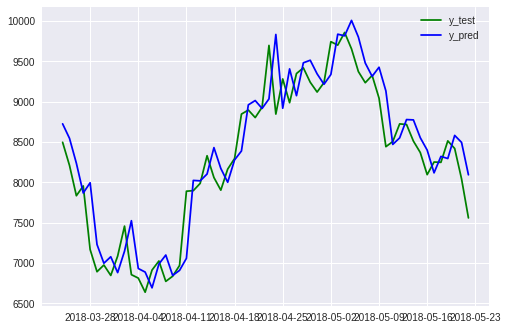

                         score
Price Range    6636.32-9858.15
Average Value          8286.84
rmse                   346.328
mae                    267.568
r2                    0.856576
Ethereum
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


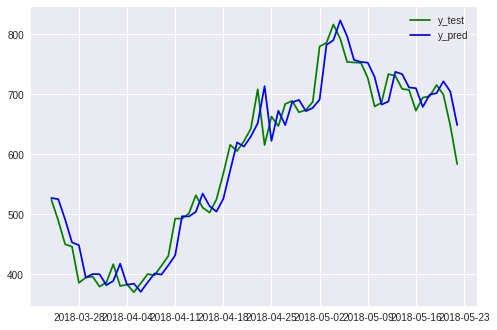

                       score
Price Range    370.29-816.12
Average Value        586.607
rmse                 32.6668
mae                  24.2056
r2                  0.942864
Ripple
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


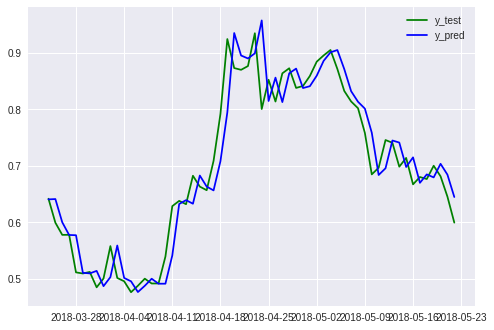

                                      score
Price Range    0.47643100000000005-0.934781
Average Value                      0.696319
rmse                              0.0437613
mae                               0.0317078
r2                                 0.902617
Tron
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


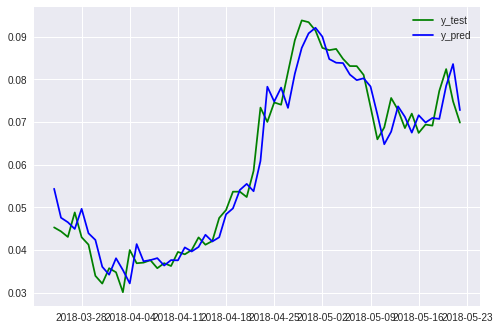

                                       score
Price Range    0.030136000000000003-0.093777
Average Value                      0.0599233
rmse                              0.00457363
mae                               0.00365183
r2                                  0.945848
Cardano
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


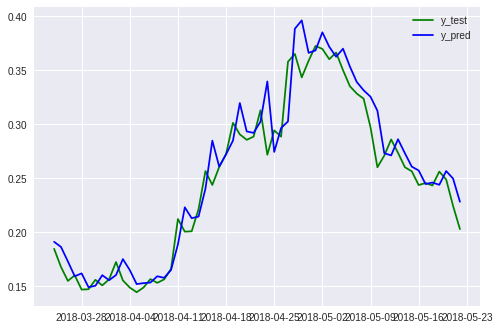

                          score
Price Range    0.144451-0.37242
Average Value          0.247119
rmse                  0.0204603
mae                   0.0146681
r2                     0.920641


In [0]:


pipeline = Pipeline([
        ('StandardScaler',StandardScaler()),   
        ('RandomForestRegressor', RandomForestRegressor(oob_score=True, random_state=9))
        ])
    
rfr_param_grid ={  
                  "RandomForestRegressor__max_features": ['sqrt', 2, "log2"],
                  "RandomForestRegressor__n_estimators": [120],
                  "RandomForestRegressor__max_depth": [40],
                  "RandomForestRegressor__max_leaf_nodes": [ 10]}
 # last 20 days of data is test data 
nextday_return_models = run_nextday_return_pipeline  (pipeline, rfr_param_grid, [1 ,3, 5,15], testdays = 60)
    

## Test run : check for 10th day returns

Bitcoin
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


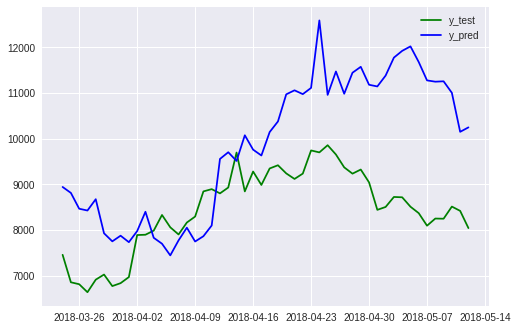

                         score
Price Range    6636.32-9858.15
Average Value          8444.04
rmse                    1838.7
mae                    1557.08
r2                     -3.2704
Ethereum
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


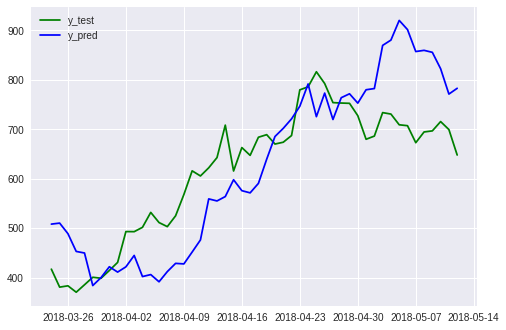

                       score
Price Range    370.29-816.12
Average Value        615.181
rmse                 101.144
mae                  84.9406
r2                  0.385259
Ripple
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


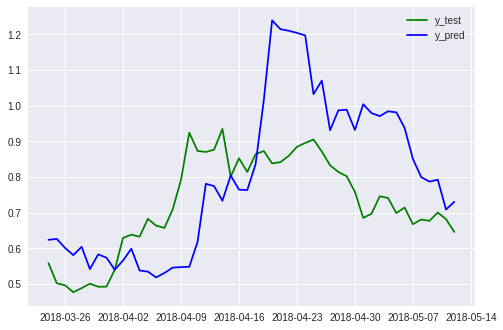

                                      score
Price Range    0.47643100000000005-0.934781
Average Value                      0.725262
rmse                                0.19002
mae                                 0.15984
r2                                 -1.00035
Tron
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


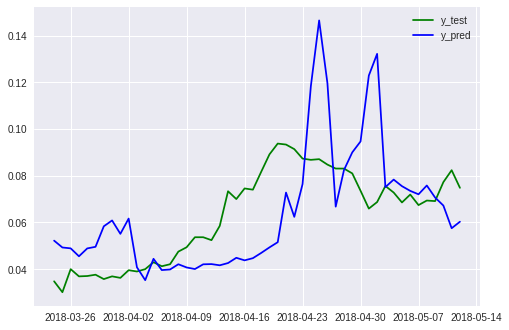

                                       score
Price Range    0.030136000000000003-0.093777
Average Value                      0.0631562
rmse                               0.0237097
mae                                0.0181341
r2                                  -0.47696
Cardano
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data


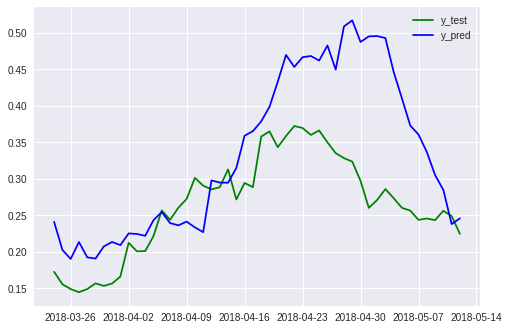

                          score
Price Range    0.144451-0.37242
Average Value          0.263994
rmse                  0.0987045
mae                    0.076808
r2                     -1.13496


In [0]:


pipeline = Pipeline([
        ('StandardScaler',StandardScaler()),   
        ('RandomForestRegressor', RandomForestRegressor(oob_score=True, random_state=9))
        ])
    
rfr_param_grid ={  
                  "RandomForestRegressor__max_features": ['sqrt', 2, "log2"],
                  "RandomForestRegressor__n_estimators": [120],
                  "RandomForestRegressor__max_depth": [40],
                  "RandomForestRegressor__max_leaf_nodes": [ 10]}
 # last 20 days of data is test data 
nextday_return_models = run_next_n_th_day_return_pipeline  (pipeline, rfr_param_grid, [1 ,3, 5,15], testdays = 60 , day =10)
    

##  Run pipeline that predicts next whole month 

In [0]:


pipeline = Pipeline([
        ('StandardScaler',StandardScaler()),   
        ('RandomForestRegressor', RandomForestRegressor(oob_score=True, random_state=9))
        ])
    
rfr_param_grid ={  
                  "RandomForestRegressor__max_features": ['sqrt', 2, "log2"],
                  "RandomForestRegressor__n_estimators": [120],
                  "RandomForestRegressor__max_depth": [40],
                  "RandomForestRegressor__max_leaf_nodes": [ 10]}
 # last 30 days of data is test data 
nextwholemonth_return_models = run_nextwholemonth_return_pipeline  (pipeline, rfr_param_grid, [1 ,3, 5,15], testdays = 60)


Bitcoin
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data
building model for predicting :Bitcoin returns on day : 1
building model for predicting :Bitcoin returns on day : 2
building model for predicting :Bitcoin returns on day : 3
building model for predicting :Bitcoin returns on day : 4
building model for predicting :Bitcoin returns on day : 5
building model for predicting :Bitcoin returns on day : 6
building model for predicting :Bitcoin returns on day : 7
building model for predicting :Bitcoin returns on day : 8
building model for predicting :Bitcoin returns on day : 9
building model for predicting :Bitcoin returns on day : 10
building model for predicting :Bitcoin returns on day : 11
building model for predicting :Bitcoi

building model for predicting :Ethereum returns on day : 21
building model for predicting :Ethereum returns on day : 22
building model for predicting :Ethereum returns on day : 23
building model for predicting :Ethereum returns on day : 24
building model for predicting :Ethereum returns on day : 25
building model for predicting :Ethereum returns on day : 26
building model for predicting :Ethereum returns on day : 27
building model for predicting :Ethereum returns on day : 28
building model for predicting :Ethereum returns on day : 29
Ripple
Get previous days high, low, market cap, open, volume
Add previous returns as a features to predict next returns
Add Simple Moving Average ( 30, 40, 50 Days)
Add Exponential Moving Average ( 30, 40, 50 Days):more weightage to latest data 
add EUR and gold returns
Fill all NAs with closest numbers
Add tweeter data
building model for predicting :Ripple returns on day : 1
building model for predicting :Ripple returns on day : 2
building model for predi

building model for predicting :Tron returns on day : 13
building model for predicting :Tron returns on day : 14
building model for predicting :Tron returns on day : 15
building model for predicting :Tron returns on day : 16
building model for predicting :Tron returns on day : 17
building model for predicting :Tron returns on day : 18
building model for predicting :Tron returns on day : 19
building model for predicting :Tron returns on day : 20
building model for predicting :Tron returns on day : 21
building model for predicting :Tron returns on day : 22
building model for predicting :Tron returns on day : 23
building model for predicting :Tron returns on day : 24
building model for predicting :Tron returns on day : 25
building model for predicting :Tron returns on day : 26
building model for predicting :Tron returns on day : 27
building model for predicting :Tron returns on day : 28
building model for predicting :Tron returns on day : 29
Cardano
Get previous days high, low, market cap,

## Predict for month based on data in each day 

In [0]:
cur_predictions_30days = {}     

for curr, curr_items in nextwholemonth_return_models.items():
  data = curr_items ["data"]
  models = curr_items["models"]   
  if(data.columns.contains("NextDayPrice")):
    data = data.drop(["NextDayPrice"], axis=1)
  
  wholemonth_model_predictions = pd.DataFrame()   

  
  for day, model in models.items():    
    y_pred_day= model.predict(data)
    wholemonth_model_predictions["date"] = data.index
    wholemonth_model_predictions["close"] = data["Close"].as_matrix()
    wholemonth_model_predictions[str(day)+"_day_return"] =y_pred_day 
    wholemonth_model_predictions[str(day)+"_day_price"] =\
              (1+wholemonth_model_predictions[str(day)+"_day_return"] )\
            * ( wholemonth_model_predictions["close"]  )
    wholemonth_model_predictions.drop([str(day)+"_day_return"], axis =1, inplace=True)
    wholemonth_model_predictions.set_index(wholemonth_model_predictions["date"], drop =True, inplace=True)
  cur_predictions_30days[curr] = wholemonth_model_predictions
  
  

In [0]:
for cur, pred in cur_predictions_30days.items():
   print ("Currency: " + cur)
   print(pred[-1:].transpose())

Currency: Bitcoin
date                   2018-05-23
date          2018-05-23 00:00:00
close                     7557.82
1_day_price               7612.34
2_day_price               7698.19
3_day_price               7831.92
4_day_price                7913.6
5_day_price                8169.9
6_day_price               8372.56
7_day_price               8527.48
8_day_price               8473.52
9_day_price                9161.7
10_day_price              8827.81
11_day_price              9130.04
12_day_price              8701.26
13_day_price              8840.74
14_day_price              8916.41
15_day_price              9180.65
16_day_price              8496.22
17_day_price              8487.09
18_day_price              8222.36
19_day_price              8196.47
20_day_price              8868.01
21_day_price              9075.04
22_day_price              8453.39
23_day_price              8669.98
24_day_price              8650.27
25_day_price              9556.22
26_day_price              1016